# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [356]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(palette="Blues_d")
sns.set()
sns.set_context("talk")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Loading data

In [338]:
# # Loading the data
# type_dict = {'CAMEO_DEUG_2015': str, 'CAMEO_INTL_2015': str}

# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype=type_dict)
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype=type_dict)

# # Writing complete data to pickle files
# azdias.to_pickle("./azdias_complete.pkl")  
# customers.to_pickle("./customer_complete.pkl")  

# # # Creating sample data
# # azdias_sample = azdias.sample(int(azdias.shape[0]*0.1))
# # customer_sample = customers.sample(int(customers.shape[0]*0.5))

# # # Writing sample data to pickle files
# # azdias_sample.to_pickle("./azdias_sample.pkl")  
# # customer_sample.to_pickle("./customer_sample.pkl")  

In [361]:
%%time

# Reading sample data from pickle files
azdias = pd.read_pickle("./azdias_complete.pkl")
customers = pd.read_pickle("./customer_complete.pkl")

Wall time: 2.12 s


In [362]:
# Loading dias attributes, that have detailed mapping of data values
list_attributes = pd.read_csv('./dias_attributes.csv', header=None).iloc[0,:].tolist()

### Exploring data

In [363]:
azdias.shape

(891221, 366)

In [364]:
customers.shape

(191652, 369)

In [365]:
customers.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4


In [366]:
azdias.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3


In [367]:
np.linspace(0,100,21)

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

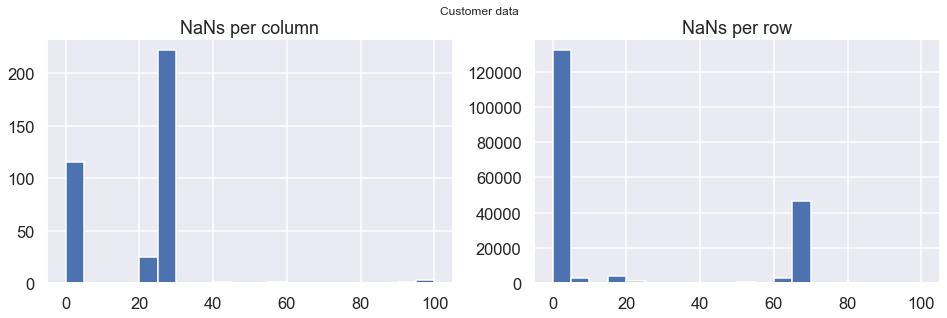

In [373]:
# Histogram of NaNs per column and rows
fig = plt.figure(figsize=(16, 4.5))
fig.suptitle('Customer data')
ax1 = plt.subplot(1,2,1);
ax1.hist(customers.isnull().mean(axis=0)*100, bins=np.linspace(0,100,21));
ax1.set_title('NaNs per column');
ax2 = plt.subplot(1,2,2);
ax2.hist(customers.isnull().mean(axis=1)*100, bins=np.linspace(0,100,21));
ax2.set_title('NaNs per row');

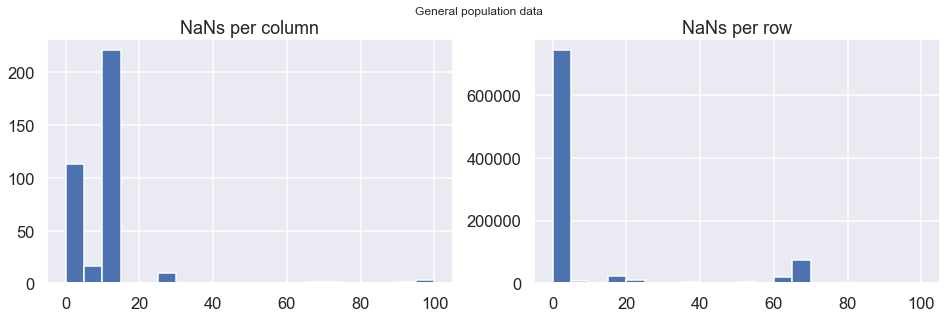

In [370]:
# Histogram of NaNs per column and rows
fig = plt.figure(figsize=(16, 4.5))
fig.suptitle('General population data')
ax1 = plt.subplot(1,2,1);
ax1.hist(azdias.isnull().mean(axis=0)*100, bins=np.linspace(0,100,21));
ax1.set_title('NaNs per column');
ax2 = plt.subplot(1,2,2);
ax2.hist(azdias.isnull().mean(axis=1)*100, bins=np.linspace(0,100,21));
ax2.set_title('NaNs per row');

Text(0.5, 1.0, 'Customers')

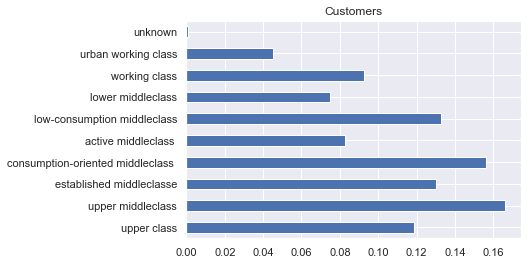

In [347]:
customers['CAMEO_DEUG_2015'].value_counts(normalize=True).sort_index().plot(kind='barh');
plt.yticks(np.arange(10), ['upper class', 'upper middleclass', 'established middleclasse',
                           'consumption-oriented middleclass ', 'active middleclass ',
                           'low-consumption middleclass', 'lower middleclass', 'working class',
                           'urban working class', 'unknown']);
plt.title('Customers');

Text(0.5, 1.0, 'General Population')

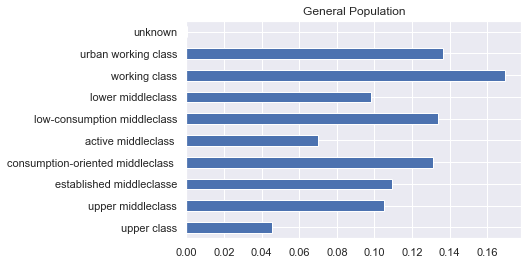

In [348]:
azdias['CAMEO_DEUG_2015'].value_counts(normalize=True).sort_index().plot(kind='barh');
plt.yticks(np.arange(10), ['upper class', 'upper middleclass', 'established middleclasse',
                           'consumption-oriented middleclass ', 'active middleclass ',
                           'low-consumption middleclass', 'lower middleclass', 'working class',
                           'urban working class', 'unknown']);
plt.title('General Population');

### Cleaning data

In [349]:
# Dropping three extra columns of customer data
customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)

# List of columns, where "0" means "unknown"
list_unknown_0 = ['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 
                  'HH_EINKOMMEN_SCORE', 'KBA05_BAUMAX', 'KBA05_GBZ', 'KKK', 'NATIONALITAET_KZ', 
                  'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'RETOURTYP_BK_S', 'TITEL_KZ', 'WOHNDAUER_2008', 
                  'W_KEIT_KIND_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 
                  'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 
                  'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 
                  'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_GESAMT_ANZ_12', 
                  'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 
                  'D19_KINDERARTIKEL_RZ', 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 
                  'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', 'D19_REISEN_RZ', 'D19_SAMMELARTIKEL_RZ', 
                  'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ', 'D19_TECHNIK_RZ', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 
                  'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL_RZ', 'D19_VERSAND_ANZ_12', 
                  'D19_VERSAND_ANZ_24', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSAND_REST_RZ', 'D19_VERSICHERUNGEN_RZ', 
                  'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VOLLSORTIMENT_RZ', 'D19_WEIN_FEINKOST_RZ']

# List of columns, where "10" means "unknown"
list_unknown_10 = ['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM', 
                   'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 
                   'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM']

In [283]:
def cleaning_data(df, test_data=False):
    """Performing several cleaning steps:
    - Replacing unknown/invalid values with NaN
    - Dropping ...
    - ...
    
    INPUT: DataFrame
    OUTPUT: Clean DataFrame
    
    """
    # Creating dictionary for renaming column names
    dict_new_columns = {}
    for attribute in set(list_attributes)-set(df.columns):
        if attribute[0:3] == 'D19' and attribute[-3:] == '_RZ':
            dict_new_columns[attribute[:-3]] = attribute
    dict_new_columns['CAMEO_INTL_2015'] = 'CAMEO_DEUINTL_2015'
    dict_new_columns['D19_BUCH_CD'] = 'D19_BUCH_RZ'
    dict_new_columns['KK_KUNDENTYP'] = 'D19_KK_KUNDENTYP'

    # Renaming column names
    df.rename(columns=dict_new_columns, inplace=True)
        
    # Replacing 0 values (means "unknown") in every column of list "list_unknown_0" with NaN
    df.loc[:,list_unknown_0].replace(0, np.nan, inplace=True)
    
    # Replacing 10 values (means "unknown") in every column of list "list_unknown_10" with NaN
    df.loc[:,list_unknown_10].replace(10, np.nan, inplace=True)
    
    # Replacing -1 values (means "unknown") in every column" with NaN
    df.replace(-1, np.nan, inplace=True)
    
    # Replacing 9 values (means "unknown") in all "KBA" columns with NaN
    df.loc[:,df.columns[df.columns.str[0:3]=='KBA']].replace(9, np.nan, inplace=True)
    
    # Replacing 9 values (means "unknown") in all "SEMIO" columns with NaN
    df.loc[:,df.columns[df.columns.str[0:5]=='SEMIO']].replace(9, np.nan, inplace=True)
    
    # Replacing 9 values (means "unknown") in "ZABEOTYP" column with NaN
    df.loc[:,'ZABEOTYP'].replace(9, np.nan, inplace=True)
    
    # Replacing 'XX' values (means "unknown") in "CAMEO_DEUINTL_2015" column with NaN
    df.loc[:,'CAMEO_DEUINTL_2015'].replace('XX', np.nan, inplace=True)
    
    # Replacing 'X' values (means "unknown") in "CAMEO_DEUG_2015" column with NaN
    df.loc[:,'CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
    
    # Data type conversions
    df['CAMEO_DEUINTL_2015'] = pd.to_numeric(df['CAMEO_DEUINTL_2015'], errors='coerce')
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'], errors='coerce')
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
    
    # Extracting year of date column and dropping it
    df['EINGEFUEGT_JAHR'] = pd.to_numeric(df['EINGEFUEGT_AM'].dt.year, downcast='integer', errors='coerce')
    df.drop('EINGEFUEGT_AM', axis=1, inplace=True)
    
    if test_data==False:
        # Dropping 'LNR' column, because these are just record numbers
        df.drop('LNR', axis=1, inplace=True)
        
        # Dropping rows with more than 30% of NaNs (row need 70% of non-NaN-values to survive)
        df.dropna(axis=0, thresh=int(round(df.shape[1]*0.7)), inplace=True)
    
        # Dropping columns with more than 30% of NaNs
        df.drop(df.columns[df.isnull().mean() > 0.3], axis=1, inplace=True)
    
    # Filling NaNs of numeric columns with the median
    num_columns = df.select_dtypes(include=['float', 'int']).columns
    for col in num_columns:
        df[col].fillna((df[col].median()), inplace=True)
        
    # Filling NaNs of categorical columns with the mode
    cat_columns = df.select_dtypes(include=['object']).columns
    for col in cat_columns:
        df[col].fillna((df[col].mode()[0]), inplace=True)
    
    # Dummy the categorical variables
    for col in cat_columns:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    
    return df

In [214]:
# Cleaning DataFrames
customers = cleaning_data(customers)
azdias = cleaning_data(azdias)

In [215]:
customers.head(3)

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W
0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0,0,0,0,1,0,0,0,0,1
2,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
3,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [216]:
azdias.head(3)

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0,0,0,0,1,0,0,0,0,1


In [18]:
# Printing missing attributes
print(f"Following attributes are in the Excel spreadsheet with detailed mapping of data values, but not in the csv files:\n")
for a in set(list_attributes)-set(customers.columns):
    print(a)

Following attributes are in the Excel spreadsheet with detailed mapping of data values, but not in the csv files:

AGER_TYP
BIP_FLAG
GEOSCORE_KLS7
D19_KK_KUNDENTYP
SOHO_FLAG
CAMEO_DEU_2015
WACHSTUMSGEBIET_NB
HAUSHALTSSTRUKTUR
OST_WEST_KZ
KBA13_CCM_1400_2500


In [19]:
# Printing missing attributes
print(f"Following attributes are in the csv files, but not in the Excel spreadsheet with detailed mapping of data values:\n")
for a in set(customers.columns)-set(list_attributes):
    print(a)

Following attributes are in the csv files, but not in the Excel spreadsheet with detailed mapping of data values:

CAMEO_DEU_2015_XX
CAMEO_DEU_2015_5F
CJT_TYP_4
KBA13_KMH_210
CAMEO_DEU_2015_6B
RT_SCHNAEPPCHEN
CAMEO_DEU_2015_5A
D19_SOZIALES
CAMEO_DEU_2015_4C
HH_DELTA_FLAG
ANZ_STATISTISCHE_HAUSHALTE
VK_DISTANZ
RT_KEIN_ANREIZ
D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL
KBA13_ANTG1
CAMEO_DEU_2015_7C
D19_VERSI_ONLINE_QUOTE_12
CAMEO_DEU_2015_9A
CAMEO_DEU_2015_6A
KBA13_GBZ
VK_ZG11
KBA13_BAUMAX
D19_LETZTER_KAUF_BRANCHE_D19_REISEN
EINGEFUEGT_JAHR
D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL
CAMEO_DEU_2015_3A
D19_KONSUMTYP_MAX
D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG
ALTERSKATEGORIE_FEIN
D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD
D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK
CAMEO_DEU_2015_1B
CAMEO_DEU_2015_8D
VHN
CAMEO_DEU_2015_4D
D19_LETZTER_KAUF_BRANCHE_D19_ENERGIE
VHA
D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE
MOBI_RASTER
CAMEO_DEU_2015_9E
CAMEO_DEU_2015_3D
KBA13_HHZ
AKT_DAT_KL
D19_LETZTER_KAUF_BRANCHE_D19_VOLLS

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA

In [20]:
# Scaling general population data for PCA
scaler = StandardScaler()
azdias_centered = scaler.fit_transform(azdias)
customers_centered = scaler.fit_transform(customers)

# Instantiating PCA
pca = PCA()

# Fitting and transforming data
azdias_pca = pca.fit_transform(azdias_centered)
customers_pca = pca.transform(customers_centered)

In [21]:
def plot_explained_variance(pca):
    """Plotting (cumulative) explained variance"""
    n_components = range(1,len(pca.explained_variance_ratio_)+1)
    
    fig = plt.figure(figsize=(16, 4.5))
    
    ax1 = plt.subplot(1,2,1)
    ax1.plot(n_components, pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle='--')
    ax1.set_title('Cumulative explained variance by components')
    ax1.set_xlabel('Number of components')
    ax1.set_ylabel('Variance')
    
    ax2 = plt.subplot(1,2,2)
    ax2.bar(n_components, pca.explained_variance_ratio_)
    ax2.set_title('Explained variance by components')
    ax2.set_xlabel('Number of components')
    ax2.set_ylabel('Variance')

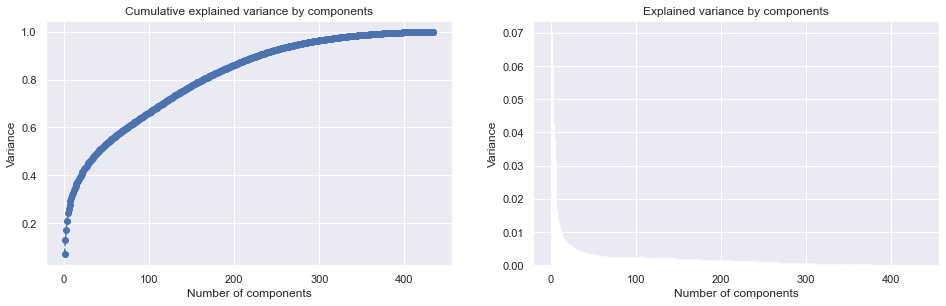

In [22]:
# Plotting explained variance of general population
plot_explained_variance(pca)

In [23]:
print(f"Number of components < 80%: {np.sum(pca.explained_variance_ratio_.cumsum()<0.8)}")

Number of components < 80%: 163


**In order to preserve about 80 % of the variance, we choose to keep 163 components.**

In [24]:
# Instantiating PCA
pca_azdias = PCA(n_components = 163)

azdias_pca = pca_azdias.fit_transform(azdias_centered)
customers_pca = pca_azdias.transform(customers_centered)

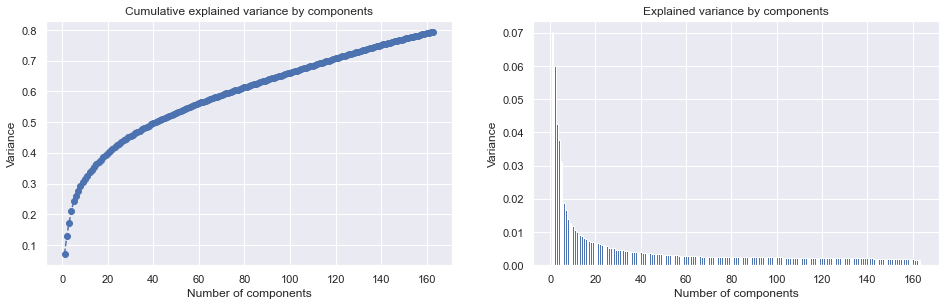

In [25]:
# Plotting explained variance of general population
plot_explained_variance(pca_azdias)

### Clustering

#### Identify number of clusters

In [26]:
def calculate_k_means_wcss(data, n_cluster_max, plot=True):
    wcss =[]
    num_clusters = range(1,n_cluster_max+1) 
    for n in num_clusters:
        kmeans_data = KMeans(n_clusters = n, init='k-means++', random_state=2)
        kmeans_data.fit(data)
        wcss.append(kmeans_data.inertia_)
    
    if plot:
        plt.figure(figsize=(8,4.5))
        plt.plot(num_clusters, wcss, marker = 'o', linestyle = '--')
        plt.title('Sum of squared distances')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()

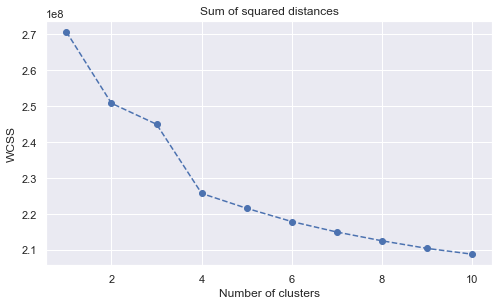

In [27]:
# Plotting Sum of squared distances of general population data
# WCSS: Within Cluster Sums of Squares
calculate_k_means_wcss(azdias_pca, 10, plot=True)

**Using the elbow-method we choose to continue clustering with 4 clusters.**

In [28]:
# Calculating K-Means of general population data
kmeans = KMeans(n_clusters = 4, init='k-means++', random_state=2)

# Compute cluster centers and predict cluster index for each sample
kmeans_azdias = kmeans.fit_predict(azdias_pca)
kmeans_customers = kmeans.predict(customers_pca)

In [29]:
# Creating DataFrames with centered data
customers_clusters = pd.DataFrame(customers_centered, columns=customers.columns)
azdias_clusters = pd.DataFrame(azdias_centered, columns=azdias.columns)

# Adding cluster column to DataFrames
customers_clusters['CLUSTER'] = kmeans_customers
azdias_clusters['CLUSTER'] = kmeans_azdias

In [30]:
customers_clusters.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_W,CLUSTER
count,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,...,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,1.403710e+05,140371.000000
mean,-7.150481e-15,7.009296e-17,5.875559e-16,-5.329606e-16,4.195104e-15,5.286077e-15,1.810346e-16,-5.622527e-16,2.920150e-15,-1.701634e-15,...,3.377309e-15,2.557500e-15,5.475186e-15,7.729176e-16,-5.961955e-16,1.427200e-16,-5.489487e-16,-1.022355e-14,-2.214229e-16,1.455415
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.298614
min,-3.755755e-01,-1.812963e+00,-2.541021e+00,-3.546653e-01,-1.267053e-01,-2.760423e-01,-1.633300e+00,-3.389400e-01,-1.336754e-01,-1.807873e+00,...,-1.221010e-01,-1.266780e-01,-4.905669e-02,-5.420896e-01,-1.598641e-01,-2.803843e-01,-2.516026e-01,-9.989778e-02,-3.393741e+00,0.000000
25%,-3.755755e-01,-5.370779e-01,-3.220584e-01,-2.820011e-01,-1.267053e-01,-2.760423e-01,-9.153099e-01,-2.655639e-01,-1.336754e-01,-8.178755e-01,...,-1.221010e-01,-1.266780e-01,-4.905669e-02,-5.420896e-01,-1.598641e-01,-2.803843e-01,-2.516026e-01,-9.989778e-02,2.946601e-01,0.000000
50%,-3.755755e-01,-5.862082e-02,-7.550702e-02,-2.820011e-01,-1.267053e-01,-2.760423e-01,-1.973194e-01,-2.655639e-01,-1.336754e-01,1.721216e-01,...,-1.221010e-01,-1.266780e-01,-4.905669e-02,-5.420896e-01,-1.598641e-01,-2.803843e-01,-2.516026e-01,-9.989778e-02,2.946601e-01,2.000000
75%,-3.755755e-01,7.388076e-01,6.641471e-01,-6.400845e-02,-1.267053e-01,-2.760423e-01,5.206711e-01,-1.188117e-01,-1.336754e-01,1.162119e+00,...,-1.221010e-01,-1.266780e-01,-4.905669e-02,-5.420896e-01,-1.598641e-01,-2.803843e-01,-2.516026e-01,-9.989778e-02,2.946601e-01,3.000000
max,3.737023e+00,1.536236e+00,3.622763e+00,3.764872e+01,3.990876e+01,1.595108e+01,1.344450e+01,2.717709e+01,3.271673e+01,6.112104e+00,...,8.189943e+00,7.894032e+00,2.038458e+01,1.844713e+00,6.255312e+00,3.566534e+00,3.974521e+00,1.001023e+01,2.946601e-01,3.000000


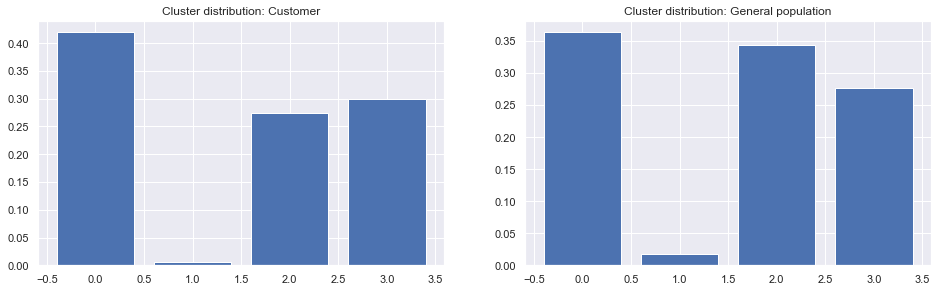

In [137]:
customer_cl_dist = customers_clusters['CLUSTER'].value_counts().sort_index()/customers.shape[0]
azdias_cl_dist = azdias_clusters['CLUSTER'].value_counts().sort_index()/azdias.shape[0]

fig = plt.figure(figsize=(16, 4.5))
ax1 = plt.subplot(1,2,1);
ax1.bar(customer_cl_dist.index, customer_cl_dist);
ax1.set_title('Cluster distribution: Customer');
ax2 = plt.subplot(1,2,2);
ax2.bar(azdias_cl_dist.index, azdias_cl_dist);
ax2.set_title('Cluster distribution: General population');

In [32]:
cl_diff = customers_clusters[customers_clusters['CLUSTER']==1].mean()-azdias_clusters[azdias_clusters['CLUSTER']==1].mean()

In [33]:
cl_diff.values

array([ 2.98789962e-01, -1.37017814e-01, -4.27262882e-01,  5.40449222e-01,
        5.24239241e-02,  4.56812383e-02, -3.00272529e-01,  5.11366436e-01,
       -8.26462072e-02, -5.40791273e-02,  1.61919662e-01,  4.57036982e-01,
        5.35124142e-01, -1.71485525e-02, -2.35421552e-03,  1.92803270e-01,
        2.83974421e-01,  5.39812267e-02, -1.32174514e-02, -3.59506852e-02,
       -2.06716226e-01, -1.60951626e-03,  3.14631191e-02, -2.01415184e-02,
        4.22109755e-02,  4.56682268e-02, -3.67733900e-02,  7.80988030e-02,
       -6.29104087e-02,  3.77432938e-02,  5.96285733e-03, -1.28367760e-01,
       -3.55879090e-02,  1.86250686e-02,  1.89311775e-02, -3.77168481e-03,
        9.86418463e-04, -4.34810439e-02, -6.60992379e-02, -8.21820954e-02,
       -2.58690162e-02, -9.87704980e-02, -1.34375551e-01,  1.64822795e-01,
        2.59652565e-02,  1.20854731e-01, -6.14196256e-02, -1.15151772e-02,
       -3.53866050e-02,  5.35735991e-03,  3.23979082e-01, -2.22339791e-03,
        3.18242910e-03,  

<AxesSubplot:>

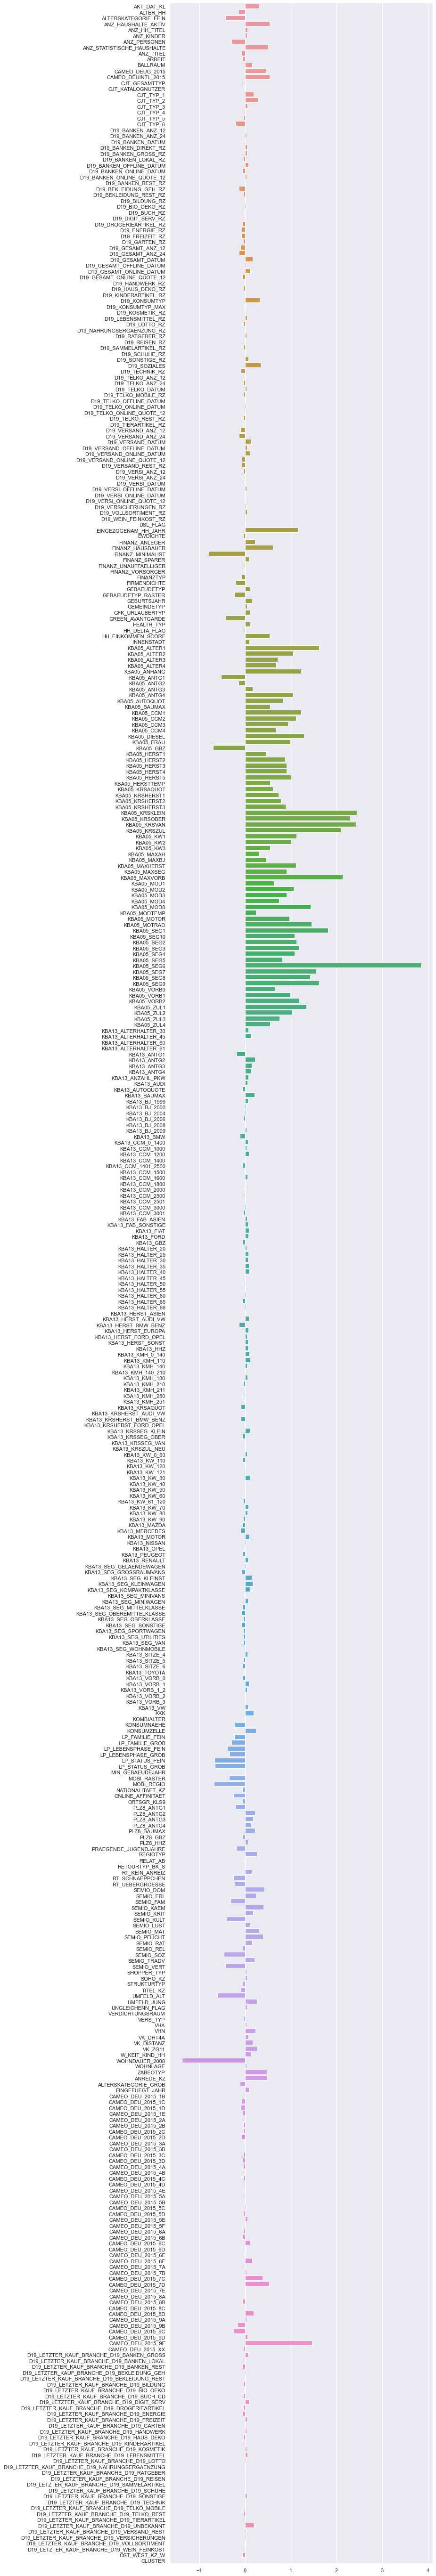

In [34]:
plt.figure(figsize=(10,100))

sns.barplot(x=cl_diff.values, y=cl_diff.index)

In [35]:
customers_centered.shape

(140371, 434)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [284]:
mailout_train = pd.read_pickle("./mailout_train.pkl")
mailout_test = pd.read_pickle("./mailout_test.pkl")

In [285]:
mailout_train.shape, mailout_test.shape

((42962, 367), (42833, 366))

In [286]:
mailout_train.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4


In [255]:
print(f"There are {mailout_train['RESPONSE'].isnull().sum()} rows with no Response value.")

There are 0 rows with no Response value.


In [256]:
print(f"Negative Response: {mailout_train['RESPONSE'].value_counts(normalize=True)[0]}")
print(f"Positive Response: {mailout_train['RESPONSE'].value_counts(normalize=True)[1]}")

Negative Response: 0.9876169638284996
Positive Response: 0.012383036171500396


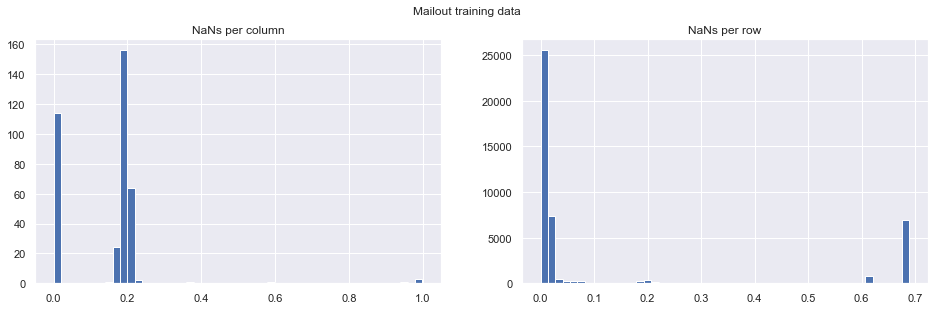

In [257]:
# Histogram of NaNs per column and rows
fig = plt.figure(figsize=(16, 4.5))
fig.suptitle('Mailout training data')
ax1 = plt.subplot(1,2,1);
ax1.hist(mailout_train.isnull().mean(axis=0), bins=50);
ax1.set_title('NaNs per column');
ax2 = plt.subplot(1,2,2);
ax2.hist(mailout_train.isnull().mean(axis=1), bins=50);
ax2.set_title('NaNs per row');

In [258]:
mailout_train = cleaning_data(mailout_train)

In [259]:
mailout_train.shape

(35000, 436)

In [260]:
print(f"Negative Response: {mailout_train['RESPONSE'].value_counts(normalize=True)[0]}")
print(f"Positive Response: {mailout_train['RESPONSE'].value_counts(normalize=True)[1]}")

Negative Response: 0.9875714285714285
Positive Response: 0.012428571428571428


In [261]:
# Create y as the Response column
y_train = mailout_train['RESPONSE']

# Drop Response column
X_train = mailout_train.drop('RESPONSE', axis=1, inplace=False)

**Unscaled Data**

In [262]:
random_state = 28

LR = LogisticRegression(random_state=random_state)
RF = RandomForestClassifier(random_state=random_state)
GB = GradientBoostingClassifier(random_state=random_state)

for clf in [LR, RF, GB]:
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    print(f"Mean cross_val_score {clf}: {np.mean(scores)}")

Mean cross_val_score LogisticRegression(random_state=28): 0.695834488498883
Mean cross_val_score RandomForestClassifier(random_state=28): 0.6048080803154348
Mean cross_val_score GradientBoostingClassifier(random_state=28): 0.7691583587259796


**StandardScaler()**

In [263]:
random_state = 28

LR = LogisticRegression(random_state=random_state)
RF = RandomForestClassifier(random_state=random_state)
GB = GradientBoostingClassifier(random_state=random_state)

for clf in [LR, RF, GB]:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    print(f"Mean cross_val_score {clf}: {np.mean(scores)}")

Mean cross_val_score LogisticRegression(random_state=28): 0.6738849689315974
Mean cross_val_score RandomForestClassifier(random_state=28): 0.6047409382240198
Mean cross_val_score GradientBoostingClassifier(random_state=28): 0.7691220622254475


**MinMaxScaler()**

In [264]:
random_state = 28

LR = LogisticRegression(random_state=random_state)
RF = RandomForestClassifier(random_state=random_state)
GB = GradientBoostingClassifier(random_state=random_state)

for clf in [LR, RF, GB]:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('clf', clf)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    print(f"Mean cross_val_score {clf}: {np.mean(scores)}")

Mean cross_val_score LogisticRegression(random_state=28): 0.6979152699603489
Mean cross_val_score RandomForestClassifier(random_state=28): 0.6066945828956711
Mean cross_val_score GradientBoostingClassifier(random_state=28): 0.7691739218012246


**From the three models Gradient Boosting Classifier has highest scores. Within Gradient Boosting there is not much difference in scores regarding scaling of data. Therefore we continue without scaling the data.**

In [265]:
%%time
random_state = 28

parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.01, 0.3],
    'n_estimators': [80, 100, 120],
    'random_state': [random_state]
}

cv = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=parameters, scoring='roc_auc')
cv.fit(X_train, y_train)

Wall time: 39min 18s


GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.3],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [80, 100, 120], 'random_state': [28]},
             scoring='roc_auc')

In [266]:
cv.best_score_

0.7713277167289349

In [267]:
cv.best_params_

{'learning_rate': 0.3,
 'loss': 'exponential',
 'n_estimators': 100,
 'random_state': 28}

In [329]:
GB_best = cv.best_estimator_
GB_best

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           random_state=28)

In [330]:
GB_best = GradientBoostingClassifier(learning_rate=0.3, loss='exponential', random_state=28)
GB_best.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           random_state=28)

**Feature importances**

In [331]:
# analyse the most important features of the model
feature_importances = pd.DataFrame({'feature_importance':GB_best.feature_importances_}, index=X_train.columns)
feature_importances.sort_values(by=['feature_importance'], ascending=False).head(10)

,feature_importance
D19_SOZIALES,0.106895
ANZ_HAUSHALTE_AKTIV,0.045081
CAMEO_DEU_2015_2A,0.031117
D19_SONSTIGE_RZ,0.025599
VHN,0.025463
LP_FAMILIE_GROB,0.025209
KBA13_KW_60,0.024276
KBA13_SEG_OBERKLASSE,0.023451
ANZ_KINDER,0.021891
CAMEO_DEU_2015_9C,0.021497


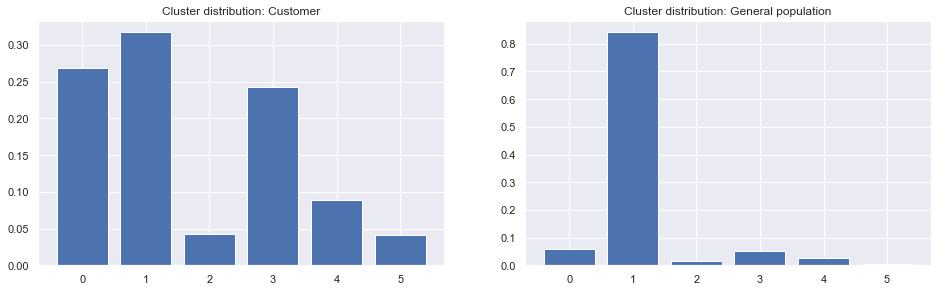

In [272]:
mailout_resp_0 = mailout_train[mailout_train['RESPONSE']==0]['D19_SOZIALES'].value_counts(normalize=True).sort_index()
mailout_resp_1 = mailout_train[mailout_train['RESPONSE']==1]['D19_SOZIALES'].value_counts(normalize=True).sort_index()

fig = plt.figure(figsize=(16, 4.5))
ax1 = plt.subplot(1,2,1);
ax1.bar(mailout_resp_0.index, mailout_resp_0);
ax1.set_title('Cluster distribution: Customer');
ax2 = plt.subplot(1,2,2);
ax2.bar(mailout_resp_1.index, mailout_resp_1);
ax2.set_title('Cluster distribution: General population');

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [313]:
mailout_test = pd.read_pickle("./mailout_test.pkl")
X_test = cleaning_data(mailout_test, test_data=True)
X_test.loc[:,X_train.columns.to_list()].shape

In [316]:
y_pred = GB_best.predict_proba(X_test.loc[:,X_train.columns.to_list()])

In [323]:
kaggle = pd.DataFrame(index=mailout_test['LNR'], data=y_pred[:,0])
kaggle.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle

,RESPONSE
LNR,
1754,0.967590
1770,0.987249
1465,0.999611
1470,0.999135
1478,0.999812
...,...
67615,0.999709
67938,0.999047
67942,0.986761


In [325]:
kaggle.to_csv('kaggle_sub.csv')